### Decision Tree Regression Task

##### 기온 및 강수량 별 모기 비율 예측

- date: 년-월-일
- mosquito_Indicator: 모기 비율
- rain(mm): 일 강수량
- mean_T(℃): 일 평균 기온
- min_T(℃): 일 최저 기온
- max_T(℃): 일 최고 기온

r2 0.8204

In [85]:
import pandas as pd

m_df = pd.read_csv('./datasets/korea_mosquito.csv',low_memory=False)

m_df

,date,mosquito_Indicator,rain(mm),mean_T(℃),min_T(℃),max_T(℃)
0,2016-05-01,254.4,0.0,18.8,12.2,26.0
1,2016-05-02,273.5,16.5,21.1,16.5,28.4
2,2016-05-03,304.0,27.0,12.9,8.9,17.6
3,2016-05-04,256.2,0.0,15.7,10.2,20.6
4,2016-05-05,243.8,7.5,18.9,10.2,26.9
...,...,...,...,...,...,...
1337,2019-12-27,5.5,0.0,-1.7,-4.6,2.6
1338,2019-12-28,5.5,0.0,1.1,-3.6,6.1
1339,2019-12-29,5.5,1.4,3.8,1.1,6.2
1340,2019-12-30,5.5,0.4,2.7,-5.7,6.8


In [4]:
m_df.isna().sum()

date                  0
mosquito_Indicator    0
rain(mm)              0
mean_T(℃)             0
min_T(℃)              0
max_T(℃)              0
dtype: int64

In [5]:
m_df.duplicated().sum()

47

In [86]:
m_df = m_df.drop(labels=['date'], axis=1)

In [87]:
m_df['mosquito_Indicator'] = m_df.pop('mosquito_Indicator')

In [33]:
m_df['mean_T(℃)'].value_counts()

mean_T(℃)
 23.3    18
 21.9    14
 23.5    11
 24.7    11
 22.6    10
         ..
 7.4      1
-8.5      1
 8.7      1
-9.9      1
-7.9      1
Name: count, Length: 384, dtype: int64

In [37]:
m_df = m_df.drop(labels=['min_T(℃)', 'max_T(℃)'], axis=1)

In [131]:
m_df['mosquito_Indicato'] = np.log1p(m_df['mosquito_Indicator'])

array([[<Axes: title={'center': 'rain(mm)'}>,
        <Axes: title={'center': 'mean_T(℃)'}>],
       [<Axes: title={'center': 'mosquito_Indicator'}>, <Axes: >]],
      dtype=object)

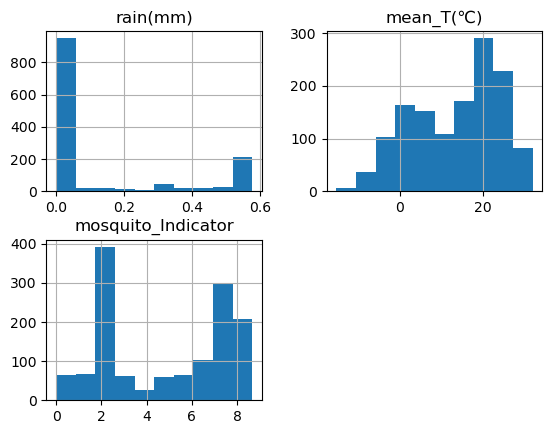

In [25]:
from sklearn.preprocessing import PowerTransformer

# box-cox: 양수만 가능
# yeo-johnson: 음수, 0 포함 가능, default

# ptf = PowerTransformer(method='box-cox', standardize=False)
ptf = PowerTransformer(standardize=False)
result = ptf.fit_transform(m_df[['mean_T(℃)']])
m_df['mean_T(℃)'] = result
m_df.hist()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

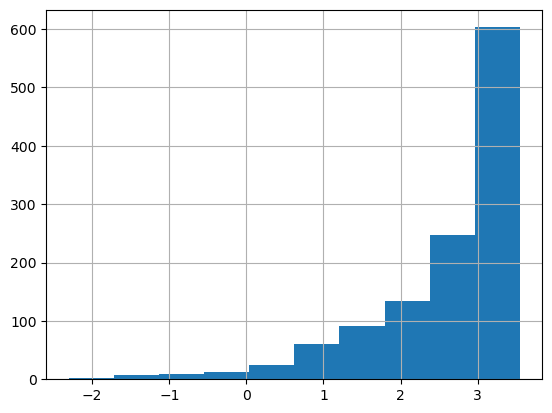

In [21]:
import numpy as np

np.log1p(m_df['mean_T(℃)']).hist()

array([[<Axes: title={'center': 'rain(mm)'}>,
        <Axes: title={'center': 'mean_T(℃)'}>],
       [<Axes: title={'center': 'min_T(℃)'}>,
        <Axes: title={'center': 'max_T(℃)'}>],
       [<Axes: title={'center': 'mosquito_Indicator'}>, <Axes: >]],
      dtype=object)

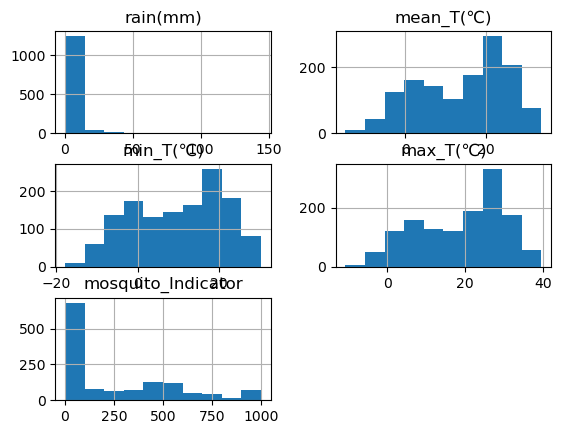

In [88]:
m_df.hist()

In [105]:
m_df = m_df.drop(labels=['mean_T(℃)'], axis=1)

In [132]:
from statsmodels.api import OLS

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:      mosquito_Indicato   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              7622.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                        0.00
Time:                        14:43:43   Log-Likelihood:                         -1820.6
No. Observations:                1342   AIC:                                      3649.
Df Residuals:                    1338   BIC:                                      3670.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [133]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['feature'] = features.columns
    return vif

In [134]:
get_vif(features)

,vif_score,feature
0,1.125058,rain(mm)
1,10.144323,min_T(℃)
2,8.615218,max_T(℃)
3,3.892077,mosquito_Indicator


In [109]:
import numpy as np
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    # MSLE = mean_squared_log_error(y_test, prediction)
    # RMSLE = np.sqrt(mean_squared_log_error(y_test, prediction))
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}'\
          .format(MSE, RMSE, R2))

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

In [154]:
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

MSE: 0.6571, RMSE: 0.8106, R2: 0.8460


In [155]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=4).fit_transform(features)

X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

In [156]:
prediction = l_r.predict(X_test)
get_evaluation(y_test.values, prediction)

MSE: 0.1611, RMSE: 0.4014, R2: 0.9622


In [149]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=1000)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor()
lgb_r = LGBMRegressor(n_estimators=100)

models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]
for model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(model.__class__.__name__)
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 0.0004, RMSE: 0.0211, R2: 0.9999
RandomForestRegressor
MSE: 0.0001, RMSE: 0.0082, R2: 1.0000
GradientBoostingRegressor
MSE: 0.0002, RMSE: 0.0149, R2: 0.9999
XGBRegressor
MSE: 0.0007, RMSE: 0.0260, R2: 0.9998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 1073, number of used features: 4
[LightGBM] [Info] Start training from score 4.010299
LGBMRegressor
MSE: 0.0004, RMSE: 0.0187, R2: 0.9999


In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

rf_r = RandomForestRegressor(random_state=124)

parameters = {'max_depth': [2,3,4], 'min_samples_split': [50,100,150], 'n_estimators': [10, 50, 100, 500, 1000]}
kfold = KFold(n_splits=10, random_state=124, shuffle=True)

# grid_rf_r = GridSearchCV(rf_r, param_grid=parameters, scoring='neg_mean_squared_error', cv=kfold)
grid_rf_r = GridSearchCV(rf_r, param_grid=parameters, scoring='r2', cv=kfold)
grid_rf_r.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=124, shuffle=True),
             estimator=RandomForestRegressor(random_state=124),
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [10, 50, 100, 500, 1000]},
             scoring='r2')

In [151]:
result_df = pd.DataFrame(grid_rf_r.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 2, 'min_samples_split': 50, 'n_e...",0.967181,43
1,"{'max_depth': 2, 'min_samples_split': 50, 'n_e...",0.967256,40
2,"{'max_depth': 2, 'min_samples_split': 50, 'n_e...",0.967291,37
3,"{'max_depth': 2, 'min_samples_split': 50, 'n_e...",0.967433,34
4,"{'max_depth': 2, 'min_samples_split': 50, 'n_e...",0.967437,31
5,"{'max_depth': 2, 'min_samples_split': 100, 'n_...",0.967181,43
6,"{'max_depth': 2, 'min_samples_split': 100, 'n_...",0.967256,40
7,"{'max_depth': 2, 'min_samples_split': 100, 'n_...",0.967291,37
8,"{'max_depth': 2, 'min_samples_split': 100, 'n_...",0.967433,34
9,"{'max_depth': 2, 'min_samples_split': 100, 'n_...",0.967437,31


In [152]:
best_result = result_df[result_df['mean_test_score'] == result_df['mean_test_score'].max()]
display(best_result)


,params,mean_test_score,rank_test_score
34,"{'max_depth': 4, 'min_samples_split': 50, 'n_e...",0.996185,1
